# Projet d'apprentissage profond pour les images - Quang-Duy Nguyen, Morgan Ramadani
## 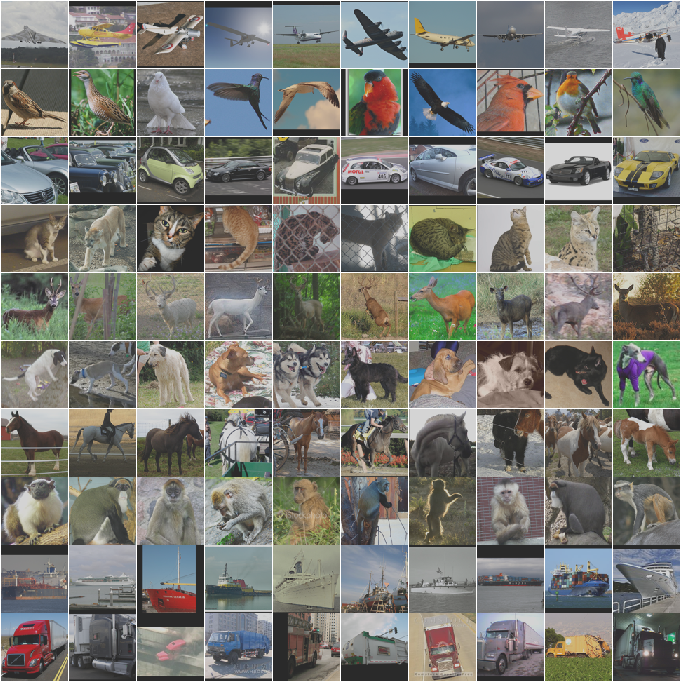

## Installation & Imports

In [2]:
from __future__ import print_function

import sys
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt
import random
# Deprecated
# from keras.preprocessing.image import save_img
from keras.utils import save_img
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import cv2

if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

try:
    from imageio import imsave
except:
    from keras.preprocessing.image import save_img
    # from scipy.misc import imsave

print(sys.version_info)

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

def save_image(image, name):
    save_img("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1

if __name__ == "__main__" :
    # download data if needed
    # download_and_extract()

    # test to check if the image is read correctly
    # with open(DATA_PATH) as f:
        # image = read_single_image(f)
        # plot_image(image)

    # test to check if the whole dataset is read correctly
    # images = read_all_images(DATA_PATH)
    # print(images.shape)

    # labels = read_labels(LABEL_PATH)
    # print(labels.shape)

    # save images to disk
    # save_images(images, labels)
    pass

sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)


In [1]:
# path to the binary files with image data
DATA_PATH = './data/stl10_binary/train_X.bin'
DATA_TEST_PATH = './data/stl10_binary/test_X.bin'

# path to the binary files with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'
LABEL_TEST_PATH = './data/stl10_binary/test_y.bin'

In [3]:
# Loading image data
images = read_all_images(DATA_PATH)
test_images = read_all_images(DATA_TEST_PATH)

labels = read_labels(LABEL_PATH)
test_labels = read_labels(LABEL_TEST_PATH)

## Data Exploration

In [5]:
# Check if there is class imbalance
print(np.array(np.unique(labels, return_counts=True)).T)

[[  1 500]
 [  2 500]
 [  3 500]
 [  4 500]
 [  5 500]
 [  6 500]
 [  7 500]
 [  8 500]
 [  9 500]
 [ 10 500]]


Classes are well balanced

In [4]:
print(images.shape)
for i in images :
    if i.shape != (96, 96, 3):
        print('dimension problem')

(5000, 96, 96, 3)


## Splitting Data

In [5]:
# Splitting train data into 80% train, 20% validation splits
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# One hot encode the labels
num_classes = 10
train_labels = tf.keras.utils.to_categorical(train_labels-1, num_classes)
valid_labels = tf.keras.utils.to_categorical(val_labels-1, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels-1, num_classes)


# Check the data sets shape
print("Training set:", train_images.shape, train_labels.shape)
print("Validation set:", val_images.shape, valid_labels.shape)
print("test set:", test_images.shape, test_labels.shape)


Training set: (4000, 96, 96, 3) (4000, 10)
Validation set: (1000, 96, 96, 3) (1000, 10)
test set: (8000, 96, 96, 3) (8000, 10)


## Baseline

### Baseline w/o Attention

In [6]:
input_shape = (96, 96, 3)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='linear')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        4640  

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
                    train_images, train_labels,
                    epochs=10,
                    validation_data=(val_images, valid_labels),
                    batch_size = 64,
)

Epoch 1/10
63/63 [==============================] - 23s 331ms/step - loss: 8.5490 - accuracy: 0.1488 - val_loss: 2.1953 - val_accuracy: 0.1760
Epoch 2/10
63/63 [==============================] - 22s 350ms/step - loss: 2.1078 - accuracy: 0.2027 - val_loss: 2.1053 - val_accuracy: 0.2100
Epoch 3/10
63/63 [==============================] - 23s 359ms/step - loss: 2.0130 - accuracy: 0.2410 - val_loss: 2.0033 - val_accuracy: 0.2660
Epoch 4/10
63/63 [==============================] - 24s 378ms/step - loss: 1.8828 - accuracy: 0.3275 - val_loss: 1.9383 - val_accuracy: 0.2750
Epoch 5/10
63/63 [==============================] - 20s 315ms/step - loss: 1.7280 - accuracy: 0.3717 - val_loss: 1.8240 - val_accuracy: 0.3210
Epoch 6/10
63/63 [==============================] - 18s 284ms/step - loss: 1.5848 - accuracy: 0.4238 - val_loss: 1.9238 - val_accuracy: 0.3270
Epoch 7/10
63/63 [==============================] - 18s 281ms/step - loss: 1.4489 - accuracy: 0.4680 - val_loss: 1.8016 - val_accuracy: 0.3330

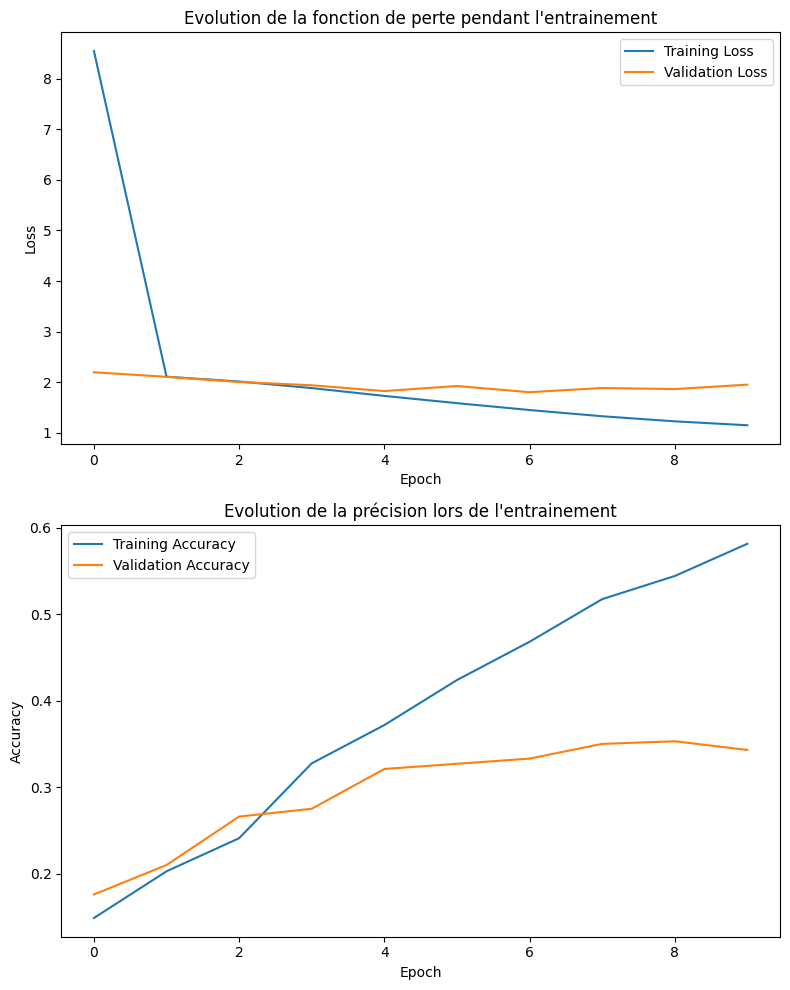

In [14]:
# 2 graphiques en 1
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot de la loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title("Evolution de la fonction de perte pendant l'entrainement")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot de la précision
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title("Evolution de la précision lors de l'entrainement")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [10]:
baseline_test_loss, baseline_test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {baseline_test_loss}")
print(f"Test Accuracy: {baseline_test_accuracy}")

250/250 [==============================] - 9s 35ms/step - loss: 2.0344 - accuracy: 0.2657
Test Loss: 2.0343892574310303
Test Accuracy: 0.265749990940094


### Baseline w Attention

In [16]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.query = layers.Dense(self.channels)
        self.key = layers.Dense(self.channels)
        self.value = layers.Dense(self.channels)
        self.gamma = self.add_weight("gamma", shape=[1], initializer="zeros", trainable=True)

    def call(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_weights = tf.nn.softmax(tf.matmul(query, key, transpose_b=True))
        attention_output = tf.matmul(attention_weights, value)
        scaled_attention = self.gamma * attention_output + x
        return scaled_attention

In [18]:
input_shape = (96, 96, 3)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='linear')(x)
x = SelfAttention()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_baseline_attention = models.Model(inputs=inputs, outputs=outputs, name="model_baseline_attention")
model_baseline_attention.summary()

Model: "model_baseline_attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 94, 94, 64)        1792      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 47, 47, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20

In [19]:
model_baseline_attention.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model_baseline_attention.fit(
                    train_images, train_labels,
                    epochs=10,
                    validation_data=(val_images, valid_labels),
                    batch_size = 64,
)

Epoch 1/10
63/63 [==============================] - 36s 537ms/step - loss: 14.7824 - accuracy: 0.1625 - val_loss: 2.1700 - val_accuracy: 0.1780
Epoch 2/10
63/63 [==============================] - 34s 537ms/step - loss: 2.0609 - accuracy: 0.2562 - val_loss: 2.0645 - val_accuracy: 0.2640
Epoch 3/10
63/63 [==============================] - 36s 579ms/step - loss: 1.9179 - accuracy: 0.3158 - val_loss: 1.9138 - val_accuracy: 0.3140
Epoch 4/10
63/63 [==============================] - 44s 695ms/step - loss: 1.7090 - accuracy: 0.3907 - val_loss: 1.9018 - val_accuracy: 0.3560
Epoch 5/10
63/63 [==============================] - 38s 599ms/step - loss: 1.5034 - accuracy: 0.4735 - val_loss: 1.7938 - val_accuracy: 0.3810
Epoch 6/10
63/63 [==============================] - 37s 587ms/step - loss: 1.4076 - accuracy: 0.5017 - val_loss: 1.9730 - val_accuracy: 0.3490
Epoch 7/10
63/63 [==============================] - 38s 604ms/step - loss: 1.2883 - accuracy: 0.5447 - val_loss: 1.8787 - val_accuracy: 0.380

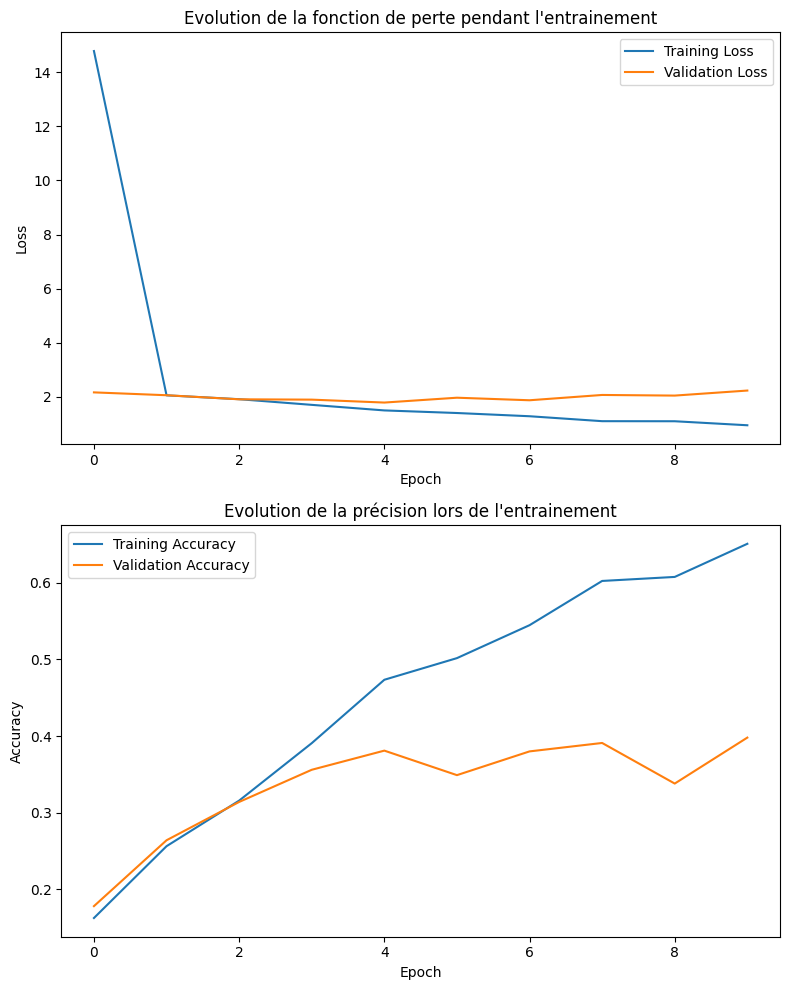

In [21]:
# 2 graphiques en 1
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot de la loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title("Evolution de la fonction de perte pendant l'entrainement")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot de la précision
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title("Evolution de la précision lors de l'entrainement")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [20]:
baseline_attention_test_loss, baseline_attention_test_accuracy = model_baseline_attention.evaluate(test_images, test_labels)
print(f"Test Loss: {baseline_attention_test_loss}")
print(f"Test Accuracy: {baseline_attention_test_accuracy}")

250/250 [==============================] - 22s 89ms/step - loss: 2.2379 - accuracy: 0.4006
Test Loss: 2.2378902435302734
Test Accuracy: 0.40062499046325684


## On ajoute également un résidu : 


In [22]:
# Définition du réseau de neurones avec résidu
input_shape = (96, 96, 3)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x_residual = layers.Dense(64, activation='linear')(x)
x_attention = SelfAttention()(x_residual)
x_combined = layers.Add()([x_residual, x_attention])
outputs = layers.Dense(10, activation='softmax')(x_combined)

model_baseline_attention_residu = models.Model(inputs=inputs, outputs=outputs, name="model_baseline_attention_residu")
model_baseline_attention_residu.summary()

Model: "model_baseline_attention_residu"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 94, 94, 64)           1792      ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 47, 47, 64)           0         ['conv2d_12[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 45, 45, 32)           18464     

In [23]:
model_baseline_attention_residu.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model_baseline_attention_residu.fit(
                    train_images, train_labels,
                    epochs=10,
                    validation_data=(val_images, valid_labels),
                    batch_size = 64,
)

Epoch 1/10
63/63 [==============================] - 44s 666ms/step - loss: 24.3657 - accuracy: 0.1338 - val_loss: 2.1568 - val_accuracy: 0.1850
Epoch 2/10
63/63 [==============================] - 37s 583ms/step - loss: 2.1022 - accuracy: 0.2075 - val_loss: 2.0789 - val_accuracy: 0.2590
Epoch 3/10
63/63 [==============================] - 35s 554ms/step - loss: 1.9708 - accuracy: 0.2792 - val_loss: 1.9932 - val_accuracy: 0.2490
Epoch 4/10
63/63 [==============================] - 35s 556ms/step - loss: 1.8546 - accuracy: 0.3200 - val_loss: 2.0008 - val_accuracy: 0.3070
Epoch 5/10
63/63 [==============================] - 36s 576ms/step - loss: 1.6610 - accuracy: 0.3898 - val_loss: 1.7743 - val_accuracy: 0.3550
Epoch 6/10
63/63 [==============================] - 38s 606ms/step - loss: 1.5671 - accuracy: 0.4168 - val_loss: 1.9544 - val_accuracy: 0.3020
Epoch 7/10
63/63 [==============================] - 37s 589ms/step - loss: 1.4465 - accuracy: 0.4737 - val_loss: 1.9217 - val_accuracy: 0.324

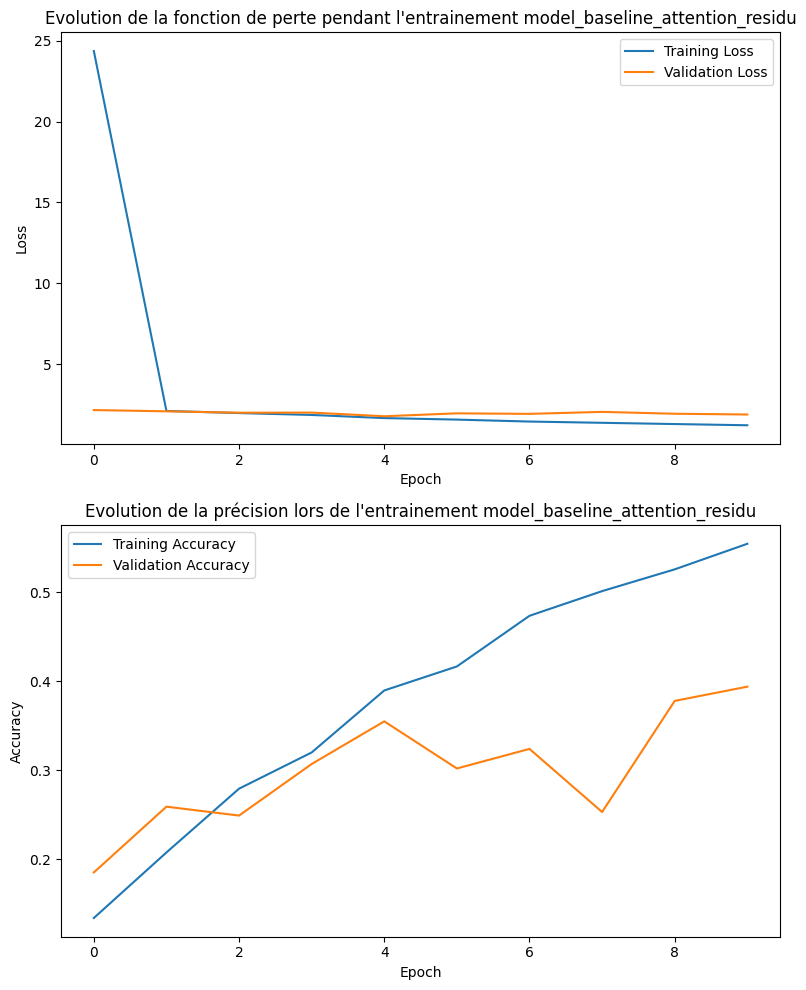

In [24]:
# 2 graphiques en 1
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot de la loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title("Evolution de la fonction de perte pendant l'entrainement model_baseline_attention_residu")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot de la précision
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title("Evolution de la précision lors de l'entrainement model_baseline_attention_residu")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [26]:
model_baseline_attention_residu_test_loss, model_baseline_attention_residu_test_accuracy = model_baseline_attention_residu.evaluate(test_images, test_labels)
print(f"Test Loss: {baseline_attention_test_loss}")
print(f"Test Accuracy: {baseline_attention_test_accuracy}")

250/250 [==============================] - 15s 60ms/step - loss: 1.9237 - accuracy: 0.3758
Test Loss: 2.2378902435302734
Test Accuracy: 0.40062499046325684


## Data Augmentation

### Horizontal Flip

In [45]:
flipped_img = np.empty_like(train_images)

for i in range(train_images.shape[0]):
    flipped_img[i] = np.fliplr(train_images[i])

In [46]:
train_images = np.append(train_images,flipped_img,axis=0)
train_labels = np.append(train_labels,train_labels,axis=0)

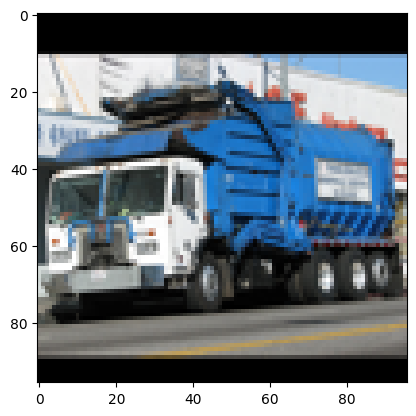

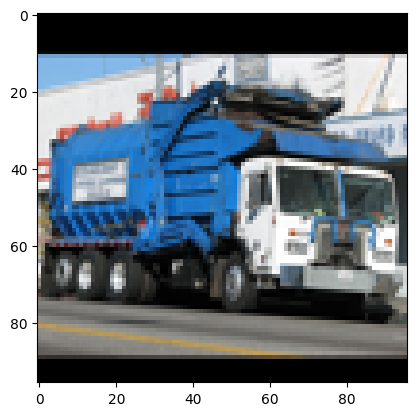

In [47]:
i = random.randint(0,5400)
# i = 0
plot_image(train_images[i])
if i - 4000 >= 0:
    plot_image(train_images[i-4000])
else :
    plot_image(train_images[i+4000])

In [48]:
print(train_images.shape)
print(train_labels.shape)

(16000, 96, 96, 3)
(16000, 10)


### Translation, Shearing, Zooming: Zoom in or out on the image.

In [49]:
# Preprocessing function to add random noise
def add_random_noise(x):
    noise = np.random.normal(0, 0.1, x.shape)  # Generate random noise
    noisy_image = x + noise  # Add noise to the image
    return noisy_image

# Preprocessing function to adjust contrast
def adjust_contrast(x):
    return x
    # contrast_factor = np.random.uniform(0.8, 1.2)  # Adjust contrast by random factor
    # adjusted_image = (x - np.mean(x)) * contrast_factor + np.mean(x)
    # return adjusted_image

def gaussian_blur(x):
    if random.random() <= 0.5 :
        return cv2.GaussianBlur(x, (5, 5), 0)
    else :
        return x

In [50]:
step2 = ImageDataGenerator(
    width_shift_range=0.2,  # Random horizontal shift by 20% of image width
    height_shift_range=0.2,  # Random vertical shift by 20% of image height
    zoom_range=0.2,  # Random zoom in/out by 20%
    shear_range=0.2,
    brightness_range=[0.9, 1.1],  # Random brightness adjustment between 0.5 and 1.5
    preprocessing_function=lambda x: gaussian_blur(adjust_contrast(add_random_noise(x))),  # Gaussian blur with kernel size of (5, 5)
    fill_mode= 'reflect'
)

In [51]:
# numbers of images generated
aug_num = 15000

In [52]:
augmented_generator = step2.flow(train_images.reshape((-1, 96, 96, 3)), train_labels, batch_size=1)

# Generate augmented images and corresponding labels
augmented_images = []
augmented_labels = []
num_augmented_images = 0

for _ in range(aug_num):
    batch = augmented_generator.next()
    augmented_images.append(batch[0][0].astype(np.uint8))
    augmented_labels.append(batch[1])
    num_augmented_images += 1

# Convert the augmented images and labels back to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Verify the shape of the augmented images and labels
print(augmented_images.shape)
print(augmented_labels.shape)

    

(15000, 96, 96, 3)
(15000, 1, 10)


In [53]:
augmented_labels = augmented_labels.reshape(aug_num,10)

In [54]:
train_images = np.append(train_images,augmented_images,axis=0)
train_labels = np.append(train_labels,augmented_labels,axis=0)

## ?

### Evalutation de la data augmentation

On réentraine le même modèle mais avec cette fois ci avec le jeu de données d'entrainement augmenté

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

# Définition du callback EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # La métrique à surveiller pour arrêter l'entraînement
    patience=4,          # Nombre de epochs sans amélioration avant de s'arrêter
    restore_best_weights=True  # Restaurer les poids du meilleur modèle
)

In [57]:
history = model_baseline_attention_residu.fit(
                    train_images, train_labels,
                    epochs=10,
                    validation_data=(val_images, valid_labels),
                    batch_size = 64,
                    callbacks=[early_stopping_callback],
)

Epoch 1/10
 80/485 [===>..........................] - ETA: 5:05 - loss: 1.8657 - accuracy: 0.3297

In [ ]:
# 2 graphiques en 1
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot de la loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title("Evolution de la fonction de perte pendant l'entrainement model_baseline_attention_residu")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot de la précision
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title("Evolution de la précision lors de l'entrainement model_baseline_attention_residu")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

### Evalutaion du modèle baseline avec attention sur les données d'entrainement augmentées.

In [28]:
test_loss, test_accuracy = model_baseline_attention.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

250/250 [==============================] - 25s 101ms/step - loss: 1.6455 - accuracy: 0.5129
Test Loss: 1.6454973220825195
Test Accuracy: 0.5128750205039978


## Modèles pré entrainés

### Les modèles pré entrainés 

In [18]:
from transformers import TFCLIPModel

model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32", from_pt=True)
# model = TFCLIPModel.from_pretrained("openai/clip-vit-large-patch14-336", from_pt=True)

/home/duy/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-08 20:46:07.816585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-08 20:46:07.832960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-08 20:46:07.833125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-08 20:46:07.833510: I tensorflow/core/plat

In [57]:
type(model)

transformers.models.clip.modeling_tf_clip.TFCLIPModel

In [34]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from transformers import CLIPProcessor, TFCLIPModel

model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# model = hub.load("https://tfhub.dev/openai/clip/1")

# # Charger vos images et étiquettes dans deux tableaux distincts
# images = ...  # Vos images prétraitées (tableau numpy)
# labels = ...  # Vos étiquettes correspondantes (tableau numpy)

# Convertir les tableaux en tenseurs TensorFlow
images_tensor = tf.convert_to_tensor(images)
labels_tensor = tf.convert_to_tensor(labels)

# Obtenir les embeddings des images
image_embeddings = model.predict(images_tensor)

# Obtenir les embeddings des étiquettes
label_embeddings = model.encode_text(labels_tensor)

# Calculer les similarités entre les embeddings d'image et d'étiquette
similarities = tf.matmul(image_embeddings, label_embeddings, transpose_b=True)

# Obtenir les indices des classes prédites pour chaque image
predicted_classes = tf.argmax(similarities, axis=1)


All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


ValueError: in user code:

    File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_filek1r14e_g.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_filetwqqbnic.py", line 36, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).clip, (), dict(input_ids=ag__.ld(input_ids), pixel_values=ag__.ld(pixel_values), attention_mask=ag__.ld(attention_mask), position_ids=ag__.ld(position_ids), return_loss=ag__.ld(return_loss), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict)), fscope)
    File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_filek1r14e_g.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_file6xg6fy_o.py", line 36, in tf__call
        ag__.if_stmt(ag__.ld(pixel_values) is None, if_body_1, else_body_1, get_state_1, set_state_1, (), 0)
    File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_file6xg6fy_o.py", line 32, in if_body_1
        raise ag__.converted_call(ag__.ld(ValueError), ('You have to specify pixel_values',), None, fscope)

    ValueError: Exception encountered when calling layer 'tfclip_model_3' (type TFCLIPModel).
    
    in user code:
    
        File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\transformers\modeling_tf_utils.py", line 1255, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\transformers\models\clip\modeling_tf_clip.py", line 1279, in call  *
            outputs = self.clip(
        File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_filek1r14e_g.py", line 37, in tf__run_call_with_unpacked_inputs
            retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
        File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_file6xg6fy_o.py", line 36, in tf__call
            ag__.if_stmt(ag__.ld(pixel_values) is None, if_body_1, else_body_1, get_state_1, set_state_1, (), 0)
        File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_file6xg6fy_o.py", line 32, in if_body_1
            raise ag__.converted_call(ag__.ld(ValueError), ('You have to specify pixel_values',), None, fscope)
    
        ValueError: Exception encountered when calling layer 'clip' (type TFCLIPMainLayer).
        
        in user code:
        
            File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\transformers\modeling_tf_utils.py", line 1255, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\transformers\models\clip\modeling_tf_clip.py", line 827, in call  *
                raise ValueError("You have to specify pixel_values")
        
            ValueError: You have to specify pixel_values
        
        
        Call arguments received by layer 'clip' (type TFCLIPMainLayer):
          • input_ids=tf.Tensor(shape=(None, 96, 96, 3), dtype=uint8)
          • pixel_values=None
          • attention_mask=None
          • position_ids=None
          • return_loss=None
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=False
    
    
    Call arguments received by layer 'tfclip_model_3' (type TFCLIPModel):
      • input_ids=tf.Tensor(shape=(None, 96, 96, 3), dtype=uint8)
      • pixel_values=None
      • attention_mask=None
      • position_ids=None
      • return_loss=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • training=False


In [31]:
from PIL import Image
import requests

from transformers import CLIPProcessor, TFCLIPModel

model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


ImportError: Unable to convert output to PyTorch tensors format, PyTorch is not installed.

## Apprentissage auto supervisé
### Idée
Dans le cas d'un jeu de données avec des données labellisées et des donnnées non labellisées, l'apprentissage semi supervisé permet d'exploiter l'ensemble du jeu de données. Nous allons tester plusieur méthodes.
### L'auto Encodeur
Un autoencodeur est un réseau de neurone qu'on décompose en 3 éléments. La phase d'encodage, l'espace latent et la phase de décodage.
- L'encodage : C'est un phase qui va être entrainée à résumer nos données d'entrée dans un espace de plus petite dimension. De cette façon, seules les informations les plus imporantes de chaques données sont retenues.
- L'espace latent : C'est l'espace dans lequel nos données sont représentées après la phase d'encodage. Sa dimension sera inférieure à celle de l'espace de départ. Cette plus faible dimension va contraindre notre réseau de neurone à ne conserverver que les éléments les plus importants des données. 
- Le décodage : Cette phase fait le chemin inverse de l'encodage. Elle prend les données dans l'espace latent et va les emmener dans l'espace de départ. Dans notre cas, cette phase nous servira pour entrainer l'encodeur. 

### Un Auto Encodeur pour les classer tous

Dans notre cas nous voullons construire un classifier. Un réseau de neurones qui va de l'espace de départ vers l'espace de départ ne nous convient pas.
Cependant, l'espace latent est exploitable. En effet, celui-ci regorge d'informations importantes sur nos données. Il a été construit avec une grande quantité de données non labellisées. Nous allons donc remplacer le décodeur par un classifier et garder l'encoceur et l'espace latent.



![image](https://blog.paperspace.com/content/images/2021/12/image-12.png)

### Charger les images non labellisées 

In [30]:
UNLABELED_DATA_PATH = './data/stl10_binary/unlabeled_X.bin'
unlabeled_images = read_all_images(UNLABELED_DATA_PATH)

### Afficheons une des images non labellisées

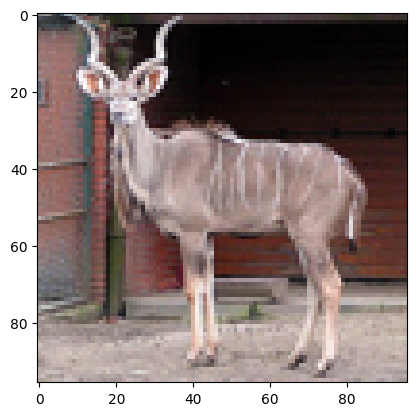

In [66]:
plot_image(unlabeled_images[0])

In [39]:

# Prétraitement des données
input_shape = train_images[0].shape
latent_dim = 64
# On n'arrive pas à entrainer sur l'ensemble de images alors on ne prend que les n premières                                                                                             
nb_of_unlabeled_images = 15000

# Division des données non labellisées en ensembles d'entraînement et de validation
train_images_unlabeled, val_images_unlabeled = train_test_split(unlabeled_images[:nb_of_unlabeled_images], test_size=0.2, random_state=42)

# Normalisation des images
train_images_unlabeled = train_images_unlabeled / 255.0
val_images_unlabeled = val_images_unlabeled / 255.0

# Construction de l'autoencodeur
input_img = Input(shape=input_shape)
                                                                                       
# Encodeur
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(latent_dim, activation='relu', name='encoded')(x)
##############################################################################################################
# Décodeur
x = Dense(12*12*128, activation='relu')(encoded)
x = tf.reshape(x, shape=(-1, 12, 12, 128))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Modèle de l'autoencodeur
autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 128)       3584      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 48, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        73792     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 32)        1846

In [40]:
# Compilation et entraînement de l'autoencodeur
autoencoder.compile(optimizer='adam', loss='mse')                                                                       
autoencoder.fit(train_images_unlabeled, train_images_unlabeled, epochs=7, batch_size=128, validation_data=(val_images_unlabeled, val_images_unlabeled))

Epoch 1/7
94/94 [==============================] - 829s 9s/step - loss: 0.0466 - val_loss: 0.0307
Epoch 2/7
94/94 [==============================] - 804s 9s/step - loss: 0.0282 - val_loss: 0.0259
Epoch 3/7
94/94 [==============================] - 844s 9s/step - loss: 0.0259 - val_loss: 0.0249
Epoch 4/7
94/94 [==============================] - 850s 9s/step - loss: 0.0237 - val_loss: 0.0224
Epoch 5/7
94/94 [==============================] - 882s 9s/step - loss: 0.0218 - val_loss: 0.0217
Epoch 6/7
94/94 [==============================] - 908s 10s/step - loss: 0.0210 - val_loss: 0.0207
Epoch 7/7
94/94 [==============================] - 906s 10s/step - loss: 0.0205 - val_loss: 0.0205


In [41]:
autoencoder.save('autoencoder_dim_64.keras')

In [36]:
# Version où on crée un nouveau modèle qui comprend l'encodeur
encoder_input = autoencoder.input
encoder_output = autoencoder.get_layer('encoded').output

# Ajout de la couche Dense de dimension 10 pour la classification
x = Dense(64, activation='relu', name='moins_2')(encoder_output)
x = Dense(32, activation='linear', name='last_dense')(x)
classification_layer = Dense(10, activation='softmax', name='classification')(x)

# Création du modèle complet avec l'encoder et la nouvelle couche de classification
classification_model = Model(inputs=encoder_input, outputs=classification_layer)

# Compilation du modèle
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history_classification_model = classification_model.fit(train_images, 
                                                        train_labels, 
                                                        epochs=3,
                                                        validation_data=(valid_images, valid_labels),
                                                        batch_size = 32,)

Epoch 1/3
100/100 [==============================] - 28s 261ms/step - loss: 4.8529 - accuracy: 0.0988 - val_loss: 2.3049 - val_accuracy: 0.0700
Epoch 2/3
100/100 [==============================] - 28s 276ms/step - loss: 2.3023 - accuracy: 0.1103 - val_loss: 2.3078 - val_accuracy: 0.0700
Epoch 3/3
100/100 [==============================] - 29s 292ms/step - loss: 2.3019 - accuracy: 0.1103 - val_loss: 2.3090 - val_accuracy: 0.0700


In [73]:
# Évaluation des performances sur l'ensemble de test
test_loss_classification_model, test_accuracy_classification_model = classification_model.evaluate(test_images, test_labels)
print('Test Loss:', test_loss_classification_model)
print('Test Accuracy:', test_accuracy_classification_model)


32/32 [==============================] - 2s 67ms/step - loss: 2.3044 - accuracy: 0.0950
Test Loss: 2.304436683654785
Test Accuracy: 0.0949999988079071


In [16]:
# Version qui va prendre les représentations dans l'espace latent
encoder_input = autoencoder.input
encoder_output = autoencoder.get_layer('encoded').output
encoder = Model(inputs=encoder_input, outputs=encoder_output)

# On va projeter les données dans l'espace latent pour commencer
encoded_train_images = encoder.predict(train_images)
encoded_test_images = encoder.predict(test_images)

# Crée un modèle de classification avec des couches supplémentaires
classifier = keras.Sequential([
    layers.Dense(64, activation="linear"),
    layers.Dense(10, activation="softmax")
])

# Compile et entraîne le classifieur sur les caractéristiques encodées
classifier.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
classifier.fit(encoded_train_images, train_labels, epochs=30, batch_size=32, )  # Utilise les étiquettes d'entraînement appropriées

32/32 [==============================] - 3s 91ms/step
Epoch 1/30
100/100 [==============================] - 1s 2ms/step - loss: 244.4898 - accuracy: 0.1187
Epoch 2/30
100/100 [==============================] - 0s 2ms/step - loss: 78.1746 - accuracy: 0.1950
Epoch 3/30
100/100 [==============================] - 0s 2ms/step - loss: 41.6871 - accuracy: 0.2319
Epoch 4/30
100/100 [==============================] - 0s 2ms/step - loss: 26.0487 - accuracy: 0.2344
Epoch 5/30
100/100 [==============================] - 0s 2ms/step - loss: 18.4821 - accuracy: 0.2406
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 19.7660 - accuracy: 0.2175
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 16.9865 - accuracy: 0.2050
Epoch 8/30
100/100 [==============================] - 0s 2ms/step - loss: 14.9063 - accuracy: 0.2344
Epoch 9/30
100/100 [==============================] - 0s 2ms/step - loss: 12.7772 - accuracy: 0.2028
Epoch 10/30
100/100 [===============

In [23]:
train_images_unlabeled[0].shape

(96, 96, 3)

In [44]:
predicted_val_images_unlabeled2 = autoencoder.predict(val_images_unlabeled)

94/94 [==============================] - 31s 328ms/step


C:\Users\ramad\AppData\Local\Temp\ipykernel_11308\1305175545.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, n, i+1)


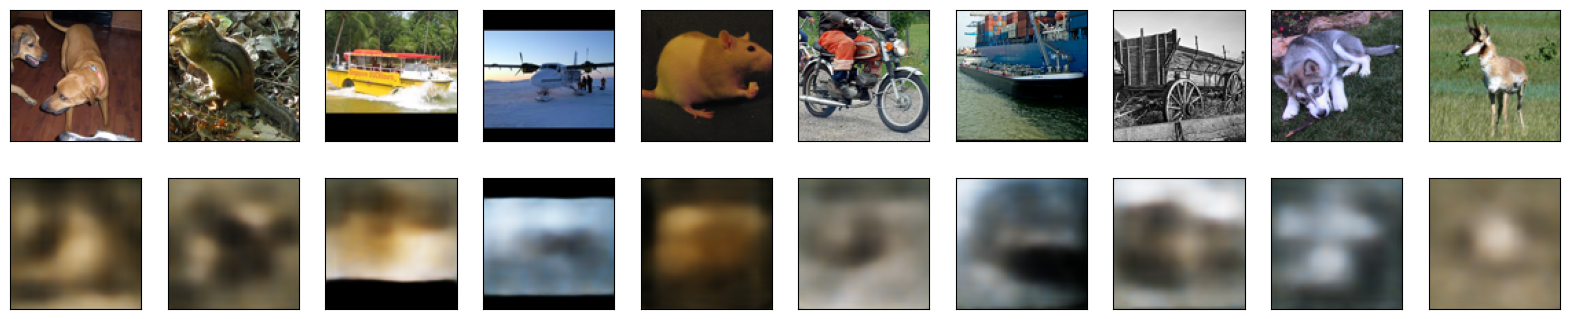

In [76]:
def display_images(original, decoded, count = 10): 
    n = count
    plt.figure(figsize=(20, 4))
    plt.title("Exemple d'image et de leur reconstruction avec l'autoencodeur")
    for i in range(n):
        # show original input image
        ax = plt.subplot(2, n, i+1)
        plt.imshow(original[300*i].reshape(96, 96, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display decoded image
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(decoded[300*i].reshape(96, 96, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()
    
display_images(val_images_unlabeled, predicted_val_images_unlabeled2, count=10)


### Méthode 2: Train + predict + train
On va maintenant faire un entrainement en 3 phases. Pour la première étape nous allons entrainer notre modèle baseline sur les données labellisées. Ensuite nous allon utiliser ce modèle pour classer les données non labellisées. Enfin nous allons entrainer de nouveau notre modèle sur le nouvel ensemble de données.

### On reprend notre modèle baseline
Il va servir à prédire les labels sur les données qui n'en ont pas.

In [34]:
# Prédire les labels des données non annotées
pred_labels_for_unlabeled_data = model_baseline_attention.predict(unlabeled_images[:5000]/255.0)

# Concatener les images pour le train
big_train_images = np.append(train_images, unlabeled_images[:5000], axis=0)

# Concaténer les labels
big_train_labels = np.append(train_labels, pred_labels_for_unlabeled_data, axis=0)

157/157 [==============================] - 12s 73ms/step


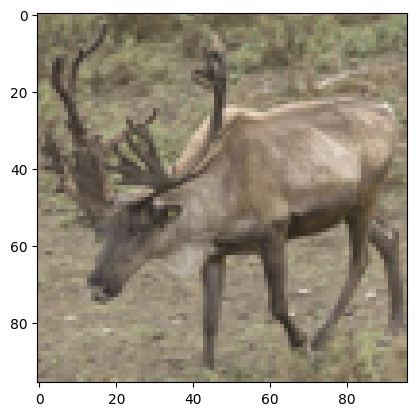

[2.6010291e-03 1.6366871e-04 2.8614876e-01 1.4745477e-02 1.8099250e-02
 4.8374082e-03 1.5885130e-03 7.8672130e-04 3.2513282e-01 3.4589636e-01]


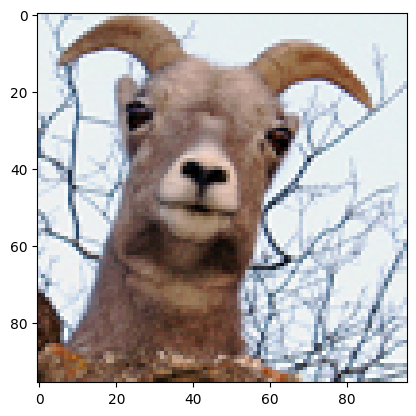

[2.6010291e-03 1.6366871e-04 2.8614876e-01 1.4745477e-02 1.8099250e-02
 4.8374082e-03 1.5885130e-03 7.8672130e-04 3.2513282e-01 3.4589636e-01]


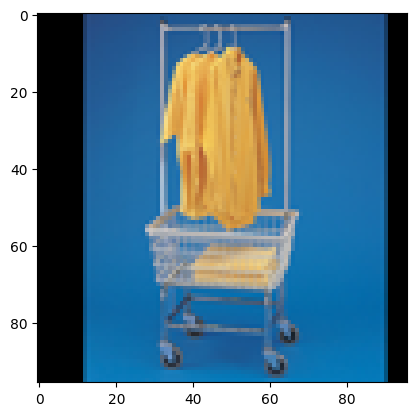

[2.6010291e-03 1.6366871e-04 2.8614876e-01 1.4745477e-02 1.8099250e-02
 4.8374082e-03 1.5885130e-03 7.8672130e-04 3.2513282e-01 3.4589636e-01]


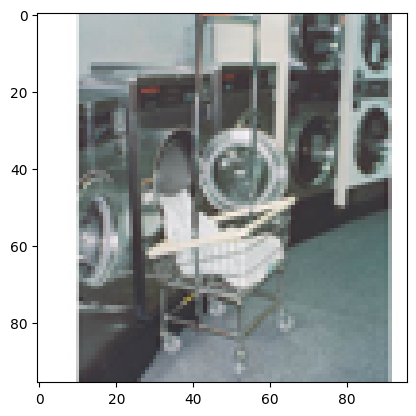

[2.6010291e-03 1.6366871e-04 2.8614876e-01 1.4745477e-02 1.8099250e-02
 4.8374082e-03 1.5885130e-03 7.8672130e-04 3.2513282e-01 3.4589636e-01]


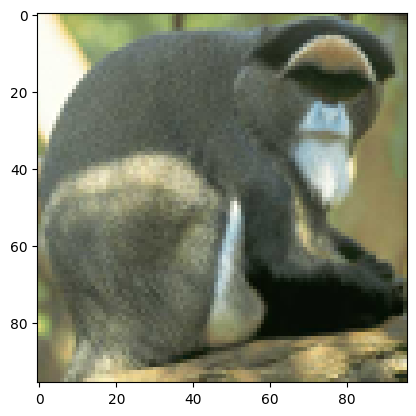

[2.6010291e-03 1.6366871e-04 2.8614876e-01 1.4745477e-02 1.8099250e-02
 4.8374082e-03 1.5885130e-03 7.8672130e-04 3.2513282e-01 3.4589636e-01]


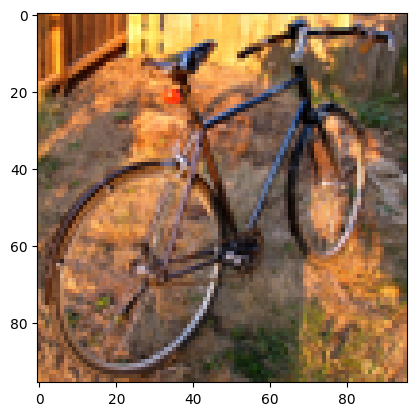

[2.6010291e-03 1.6366871e-04 2.8614876e-01 1.4745477e-02 1.8099250e-02
 4.8374082e-03 1.5885130e-03 7.8672130e-04 3.2513282e-01 3.4589636e-01]


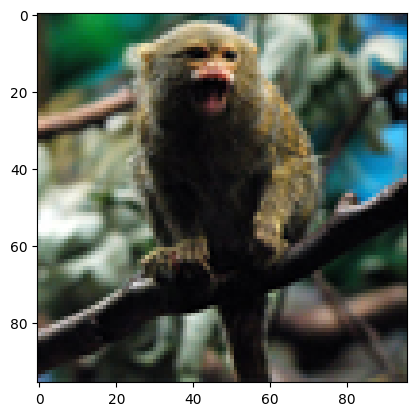

[2.6010291e-03 1.6366871e-04 2.8614876e-01 1.4745477e-02 1.8099250e-02
 4.8374082e-03 1.5885130e-03 7.8672130e-04 3.2513282e-01 3.4589636e-01]


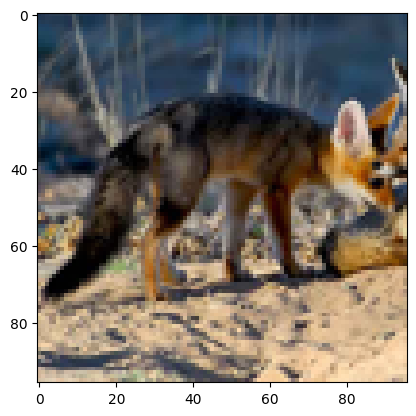

[2.6010291e-03 1.6366871e-04 2.8614876e-01 1.4745477e-02 1.8099250e-02
 4.8374082e-03 1.5885130e-03 7.8672130e-04 3.2513282e-01 3.4589636e-01]


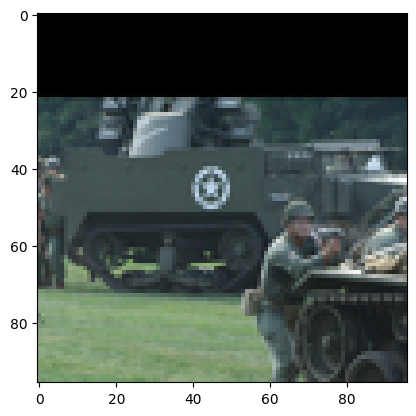

[2.6010291e-03 1.6366871e-04 2.8614876e-01 1.4745477e-02 1.8099250e-02
 4.8374082e-03 1.5885130e-03 7.8672130e-04 3.2513282e-01 3.4589636e-01]


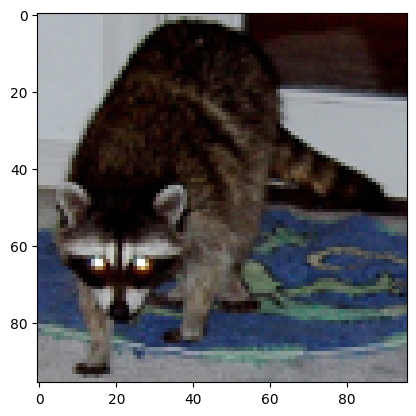

[2.6010291e-03 1.6366871e-04 2.8614876e-01 1.4745477e-02 1.8099250e-02
 4.8374082e-03 1.5885130e-03 7.8672130e-04 3.2513282e-01 3.4589636e-01]


In [46]:
# observons les résultats de cette labellisatoin : 

for i in range(10):
    plot_image(big_train_images[-i])
    print(big_train_labels[-1])

In [35]:
# taille du nouveau dataset
print("Le nouveau dataset d'entrainement augmenté et avec les nouvelles données labellisées est de dimensions : ", big_train_images.shape)

Le nouveau dataset d'entrainement augmenté et avec les nouvelles données labellisées est de dimensions :  (28000, 96, 96, 3)


### Nouvel entrainement pour un nouveau jeu de données
Nous allons maintenant réentrainer le modèle sur ce nouvel ensemble de données.

In [37]:
# Donner plus d'importance aux données qui ont de vrais labels

sample_weights = np.ones(len(train_images))  # Initialisation avec des poids égaux
sample_weights[:4000] = 2.0  # Donnez plus d'importance aux 5000 premiers échantillons

# fit du nouveau modèle
big_history = model_baseline_attention.fit(
                    train_images, train_labels,
                    epochs=5,
                    validation_data=(val_images, valid_labels),
                    batch_size = 256,)


Epoch 1/5
90/90 [==============================] - 255s 3s/step - loss: 0.8429 - accuracy: 0.6945 - val_loss: 1.6931 - val_accuracy: 0.5310
Epoch 2/5
90/90 [==============================] - 251s 3s/step - loss: 0.7450 - accuracy: 0.7315 - val_loss: 1.8707 - val_accuracy: 0.5360
Epoch 3/5
90/90 [==============================] - 248s 3s/step - loss: 0.6691 - accuracy: 0.7600 - val_loss: 1.8657 - val_accuracy: 0.5230
Epoch 4/5
90/90 [==============================] - 214s 2s/step - loss: 0.6142 - accuracy: 0.7804 - val_loss: 2.1792 - val_accuracy: 0.5270
Epoch 5/5
90/90 [==============================] - 211s 2s/step - loss: 0.5834 - accuracy: 0.7898 - val_loss: 2.3011 - val_accuracy: 0.5090


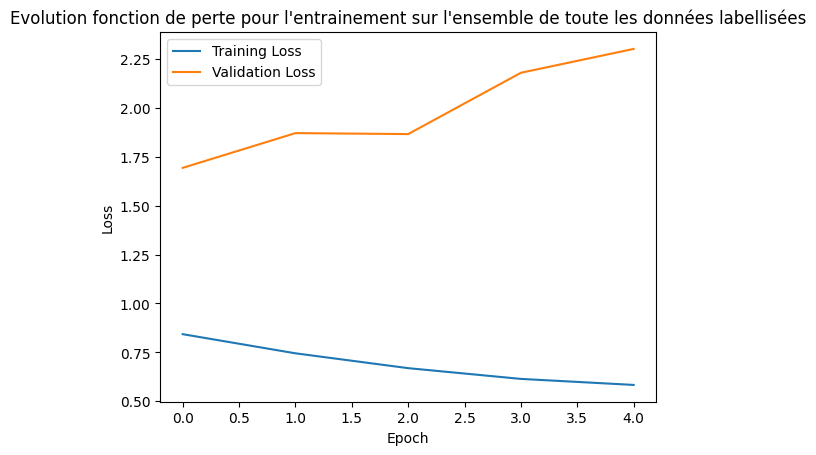

In [65]:
# Affiche le graphique de la loss
plt.plot(big_history.history['loss'], label='Training Loss')
plt.plot(big_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Evolution fonction de perte pour l'entrainement sur l'ensemble de toute les données labellisées")
plt.legend()
plt.show()

In [38]:
# Évaluation des performances sur l'ensemble de test
test_loss_big_train, test_accuracy_big_train = model_baseline_attention.evaluate(test_images, test_labels)
print('Test Loss:', test_loss_big_train)
print('Test Accuracy:', test_accuracy_big_train)

250/250 [==============================] - 19s 78ms/step - loss: 2.3065 - accuracy: 0.5086
Test Loss: 2.3064944744110107
Test Accuracy: 0.5086249709129333


## Essaie d'un resnet

In [63]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, strides=1, activation='relu'):
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if strides != 1 or inputs.shape[-1] != filters:
        inputs = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(inputs)
        inputs = BatchNormalization()(inputs)

    x = Add()([x, inputs])
    x = Activation(activation)(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, filters=64)
    x = resnet_block(x, filters=64)
    x = resnet_block(x, filters=128, strides=2)
    x = resnet_block(x, filters=128)
    # x = resnet_block(x, filters=256, strides=2)
    # x = resnet_block(x, filters=256)
    # x = resnet_block(x, filters=512, strides=2)
    # x = resnet_block(x, filters=512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (96, 96, 3)
num_classes = 10

model = build_resnet(input_shape, num_classes)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_229 (Conv2D)         (None, 48, 48, 64)           9472      ['input_8[0][0]']             
                                                                                                  
 batch_normalization_214 (B  (None, 48, 48, 64)           256       ['conv2d_229[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_43 (Activation)  (None, 48, 48, 64)           0         ['batch_normalization_21

Epoch 1/3
90/90 [==============================] - 400s 4s/step - loss: 1.5234 - accuracy: 0.4233 - val_loss: 3.0795 - val_accuracy: 0.2490
Epoch 2/3
90/90 [==============================] - 411s 5s/step - loss: 1.1684 - accuracy: 0.5653 - val_loss: 2.5328 - val_accuracy: 0.2790
Epoch 3/3
90/90 [==============================] - 404s 4s/step - loss: 1.0014 - accuracy: 0.6298 - val_loss: 2.0890 - val_accuracy: 0.3920


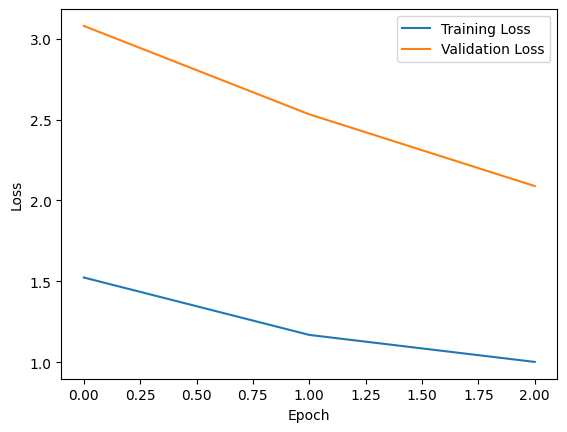

In [64]:
import matplotlib.pyplot as plt

# Compile le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîne le modèle
history = model.fit(
                    train_images, train_labels,
                    epochs=3,
                    validation_data=(val_images, valid_labels),
                    batch_size = 256,)

# Affiche le graphique de la loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [77]:
batch_size = 50
img_width, img_height, img_channels = 96, 96, 3
no_classes = 10
no_epochs = 50

In [78]:
#define the input shape
input_img = Input(shape = (img_width, img_height, img_channels))

# convert to float32 format
x_train = train_images.astype('float32')
x_test = test_images.astype('float32')

# Normalize the data
x_train = x_train / 255
x_test = x_test / 255


x = Conv2D(64, (3, 3), activation='relu', padding='same') (input_img)
x = MaxPooling2D((2, 2)) (x)

x = Conv2D(32, (3, 3), activation='relu', padding='same') (x)
x = MaxPooling2D((2, 2)) (x)

x = Conv2D(16, (3, 3), activation='relu', padding='same') (x)
#x = MaxPooling2D((2, 2)) (x)

x = Conv2D(8, (3, 3), activation='relu', padding='same') (x)
encoded = MaxPooling2D((2, 2)) (x)

x = Conv2D(8, (3, 3), activation='relu', padding='same') (encoded)
x = UpSampling2D((2, 2)) (x)

x = Conv2D(16, (3, 3), activation='relu', padding='same') (x)
x = UpSampling2D((2, 2)) (x)

x = Conv2D(32, (3, 3), activation='relu', padding='same') (x)
x = UpSampling2D((2, 2)) (x)

x = Conv2D(64, (3, 3), activation='relu', padding='same') (x)
#x = UpSampling2D((2, 2)) (x)

decoded = Conv2D(3, (3, 3), padding='same') (x)

cae = Model(input_img,decoded)
cae.compile(optimizer = 'adam', loss ='mse', metrics=['accuracy'] )
cae.summary()



Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_239 (Conv2D)         (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_240 (Conv2D)         (None, 48, 48, 32)        18464     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_241 (Conv2D)         (None, 24, 24, 16)        4624

In [79]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

np.random.seed(123)
history = cae.fit(x_train,x_train,
           epochs = 100,
           batch_size = 50,
           validation_data = (x_test, x_test),
           callbacks=[early_stopping_monitor])

Epoch 1/100


: 

: 

In [ ]:
decoded_data = cae.predict(x_test)
display_images(x_test, decoded_data)